# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.metrics import accuracy_score
import math 

In [2]:
#ptl_data=pd.read_csv("D:\\FP2\\all commercial\\all commercial\\petroleum liquid\\Total_consumption_petroleum_liquids_Alaska_all_commercial_(total)_monthly.csv")
ptl_data=pd.read_csv("Total_consumption_petroleum_liquids_Alaska_all_commercial_(total)_monthly.csv")
ptl_data=ptl_data.rename(columns={'Series ID: ELEC.CONS_TOT.PEL-AK-96.M thousand barrels':'ptl_Con'})
mean_values = (ptl_data['ptl_Con'].shift() + ptl_data['ptl_Con'].shift(-1)) / 2

# Replace missing values with the mean of the preceding and following values
ptl_data['ptl_Con'].fillna(method='ffill', inplace=True)
ptl_data['D'] = ptl_data['Month'].str.slice(0, 2)
ptl_data['M'] = ptl_data['Month'].str.slice(3, 5)
ptl_data['Y'] = ptl_data['Month'].str.slice(6, 10)
ptl_data['Date1'] = ptl_data['Y']+'-'+ptl_data['M']+'-'+ptl_data['D']
ptl_data['Date'] = pd.to_datetime(ptl_data['Date1'])
ptl_data3=ptl_data.sort_values(['Date'],ascending=True)
ptl_data4=ptl_data3[['Date','ptl_Con']]
ptl_data4

,Date,ptl_Con
0,2001-01-01,1.590
1,2001-02-01,2.890
2,2001-03-01,2.910
3,2001-04-01,1.380
4,2001-05-01,1.370
...,...,...
256,2022-05-01,6.962
257,2022-06-01,6.962
258,2022-07-01,6.962
259,2022-08-01,6.962


In [3]:
#libaries for time series
from statsmodels.tools.eval_measures import rmse
import seaborn as sns
import statsmodels.api as sm
import itertools
from statsmodels.tsa.arima_model import ARIMA, ARMA
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing 

<AxesSubplot:xlabel='Date'>

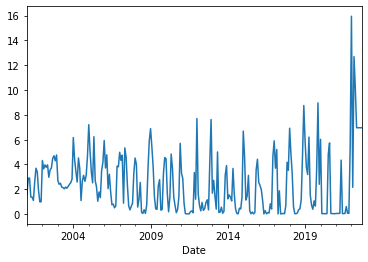

In [4]:
# dataset creation
#coal_data4=coal_data3.copy()
df = ptl_data4.set_index("Date")
df['ptl_Con'].plot(style="-")

In [5]:
y=df['ptl_Con']
y_to_val = y['2018-12-01':] # dataset to train
y_to_train = y[:'2018-12-01'] # last X months for test  
#predict_date = len(y) - len(y[:'Q4 2017']-1) 
train=pd.DataFrame(y_to_train)
test=pd.DataFrame(y_to_val)


# Seasonal Naive Forecast model

In [6]:
def pysnaive(train_series,seasonal_periods,forecast_horizon):
    '''
    Python implementation of Seasonal Naive Forecast. 
    This should work similar to https://otexts.com/fpp2/simple-methods.html
    Returns two arrays
     > fitted: Values fitted to the training dataset
     > fcast: seasonal naive forecast
    
    Author: Sandeep Pawar
    
    Date: Apr 9, 2020
    
    Ver: 1.0
    
    train_series: Pandas Series
        Training Series to be used for forecasting. This should be a valid Pandas Series. 
        Length of the Training set should be greater than or equal to number of seasonal periods
        
    Seasonal_periods: int
        No of seasonal periods
        Yearly=1
        Quarterly=4
        Monthly=12
        Weekly=52
        

    Forecast_horizon: int
        Number of values to forecast into the future
    
    e.g. 
    fitted_values = pysnaive(train,12,12)[0]
    fcast_values = pysnaive(train,12,12)[1]
    '''
    
    if len(train_series)>= seasonal_periods: #checking if there are enough observations in the training data
        
        last_season=train_series.iloc[-seasonal_periods:]
        
        reps=np.int(np.ceil(forecast_horizon/seasonal_periods))
        
        fcarray=np.tile(last_season,reps)
        
        fcast=pd.Series(fcarray[:forecast_horizon])
        
        fitted = train_series.shift(seasonal_periods)
        
    else:
        fcast=print("Length of the trainining set must be greater than number of seasonal periods") 
    
    return fitted, fcast

In [7]:
import mlflow
import pandas as pd
import pmdarima as pm
# from fbprophet import Prophet
from prophet import Prophet
import matplotlib.pyplot as plt

In [8]:
# Set up mlflow tracking
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("forecasting-model-petroluem-liquid")
mlflow.tensorflow.autolog()

2023-02-25 22:58:39.041585: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023/02/25 22:58:42 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Cmd('git') failed due to: exit code(1)
  cmdline: git version
  stderr: 'xcrun: error: invalid active developer path (/Library/Developer/CommandLineTools), missing xcrun at: /Library/Developer/CommandLineTools/usr/bin/xcrun'
2023/02/25 22:58:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Mean Absolute error is 1.7050022222222223
MAPE is 180.89629130520987
RMSE is 2.409033041621295


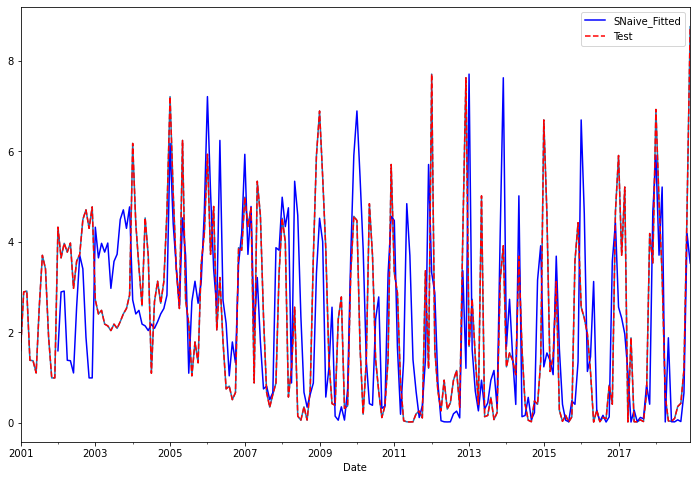

In [9]:
# Start mlflow run
with mlflow.start_run():
    mlflow.set_tag("data scientist", "kb")
    #Fitted values
    py_snaive_fit = pysnaive(train["ptl_Con"], 
                         seasonal_periods=12,
                         forecast_horizon=len(train))[0]

    #forecast
    py_snaive = pysnaive(train["ptl_Con"], 
                         seasonal_periods=12,
                         forecast_horizon=len(train))[1]

    #Residuals
    py_snaive_resid = (train["ptl_Con"] - py_snaive_fit).dropna()



    predictions=train.copy()
    predictions["py_snaive"] = py_snaive.values 


    predictions

    # Charting the output
    pd.plotting.register_matplotlib_converters()
    fig = plt.figure(figsize=(10,5))
    train["ptl_Con"].plot(figsize=(12,8))#, style="--", color="gray", legend=True, label="Train")
    py_snaive_fit.plot(color="b", legend=True, label="SNaive_Fitted")
    predictions["ptl_Con"].plot(style="--",color="r", legend=True, label="Test")
    #predictions["py_snaive"].plot(color="b", legend=True, label="Snaive_fc");


    #MAE
    n=mean_absolute_error(predictions["ptl_Con"], predictions["py_snaive"])
    print("Mean Absolute error is",n)

    #MAPE
    k=np.mean(np.abs((predictions["ptl_Con"] - predictions["py_snaive"]) / predictions["ptl_Con"])) * 100
    print("MAPE is",k)

    #RMSE
    r=math.sqrt(mean_squared_error(predictions["ptl_Con"], predictions["py_snaive"]))
    print("RMSE is",r)

    # Log model parameters and metrics to mlflow
    mlflow.log_param("model", "py_snaive")
    #mlflow.set_tag("model", py_snaive_fit)
    mlflow.log_metric("mae", n)
    mlflow.log_metric("mape", k)
    mlflow.log_metric("rmse", r)
    mlflow.log_figure(fig, "my-plot.png")
    
    
    # Save model as artifact
    mlflow.sklearn.log_model(py_snaive_fit, "model")

# Holt-Winter's Method

Mean Absolute error is 3.13464148234562
MAPE is 1974.1724438548747
RMSE is 4.284328300518489


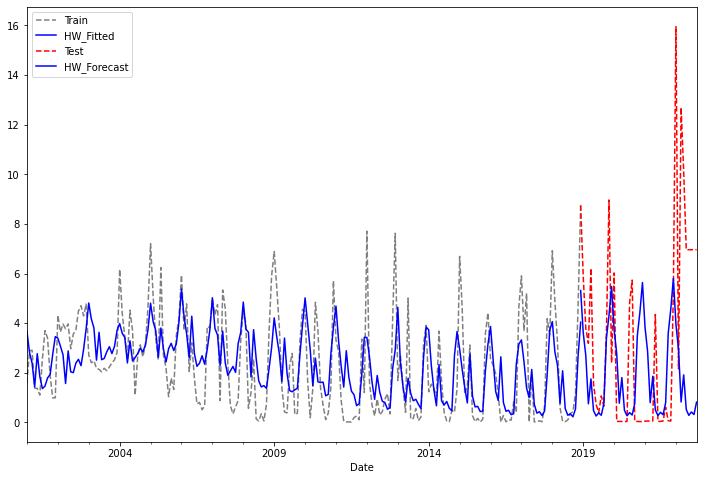

In [10]:
with mlflow.start_run():
    hw_model = ExponentialSmoothing(train["ptl_Con"],
                              trend    ="mul",
                              seasonal = "mul", 
                              seasonal_periods=12).fit()

    hw_fitted = hw_model.fittedvalues

    hw_resid = hw_model.resid

    #Adding the mean of the residuals to correct the bias.
    py_hw = hw_model.forecast(len(test["ptl_Con"]))+np.mean(hw_resid)
    py_hw=pd.DataFrame(py_hw)
    py_hw.columns=['py_hw']
    py_hw=py_hw.reset_index()
    py_hw=py_hw.drop('index',axis=1)
    predictions1=test.copy()
    predictions1=predictions1.reset_index()
    py_hw2 = pd.concat([predictions1,py_hw],axis=1)
    py_hw2=py_hw2.set_index('Date')
    py_hw2

    fig = plt.figure(figsize=(10,5))
    train["ptl_Con"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
    hw_fitted.plot(color="b", legend=True, label="HW_Fitted")
    py_hw2["ptl_Con"].plot(style="--",color="r", legend=True, label="Test")
    py_hw2["py_hw"].plot(color="b", legend=True, label="HW_Forecast")

    #MAE
    n=mean_absolute_error(py_hw2.ptl_Con, py_hw2["py_hw"])
    print("Mean Absolute error is",n)

    #MAPE
    k=np.mean(np.abs((py_hw2.ptl_Con - py_hw2["py_hw"]) / py_hw2.ptl_Con)) * 100
    print("MAPE is",k)

    #RMSE
    r=math.sqrt(mean_squared_error(py_hw2.ptl_Con, py_hw2["py_hw"]))
    print("RMSE is",r)
    mlflow.log_param("model", "Holt-Winter")
    mlflow.log_metric("mae", n)
    mlflow.log_metric("mape", k)
    mlflow.log_metric("rmse", r)
    mlflow.log_figure(fig, "Holt-winter.png")
    # Save model as artifact
    mlflow.sklearn.log_model(hw_model, "model")

# ETS Model

In [11]:
#ptl_data=pd.read_csv("D:\\FP2\\all commercial\\all commercial\\petroleum liquid\\Total_consumption_petroleum_liquids_Alaska_all_commercial_(total)_monthly.csv")
ptl_data=pd.read_csv("Total_consumption_petroleum_liquids_Alaska_all_commercial_(total)_monthly.csv")
ptl_data=ptl_data.rename(columns={'Series ID: ELEC.CONS_TOT.PEL-AK-96.M thousand barrels':'ptl_Con'})
mean_values = (ptl_data['ptl_Con'].shift() + ptl_data['ptl_Con'].shift(-1)) / 2

# Replace missing values with the mean of the preceding and following values
ptl_data['ptl_Con'].fillna(method='ffill', inplace=True)
ptl_data['D'] = ptl_data['Month'].str.slice(0, 2)
ptl_data['M'] = ptl_data['Month'].str.slice(3, 5)
ptl_data['Y'] = ptl_data['Month'].str.slice(6, 10)
ptl_data['Date1'] = ptl_data['Y']+'-'+ptl_data['M']+'-'+ptl_data['D']
ptl_data['Date'] = pd.to_datetime(ptl_data['Date1'])
ptl_data3=ptl_data.sort_values(['Date'],ascending=True)
ptl_data4=ptl_data3[['Month','ptl_Con']]
df = ptl_data4.set_index("Month")
y=df['ptl_Con']
y_to_val = y['01-12-2018':] # dataset to train
y_to_train = y[:'01-12-2018'] # last X months for test  
#predict_date = len(y) - len(y[:'Q4 2017']-1) 
train=pd.DataFrame(y_to_train)
test=pd.DataFrame(y_to_val)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78358D+00    |proj g|=  2.56753D-02

At iterate    5    f=  1.75616D+00    |proj g|=  2.71065D-03

At iterate   10    f=  1.75269D+00    |proj g|=  6.33275D-03

At iterate   15    f=  1.75195D+00    |proj g|=  5.32961D-05

At iterate   20    f=  1.75192D+00    |proj g|=  2.74518D-04

At iterate   25    f=  1.75191D+00    |proj g|=  3.76668D-05

At iterate   30    f=  1.75191D+00    |proj g|=  1.71896D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

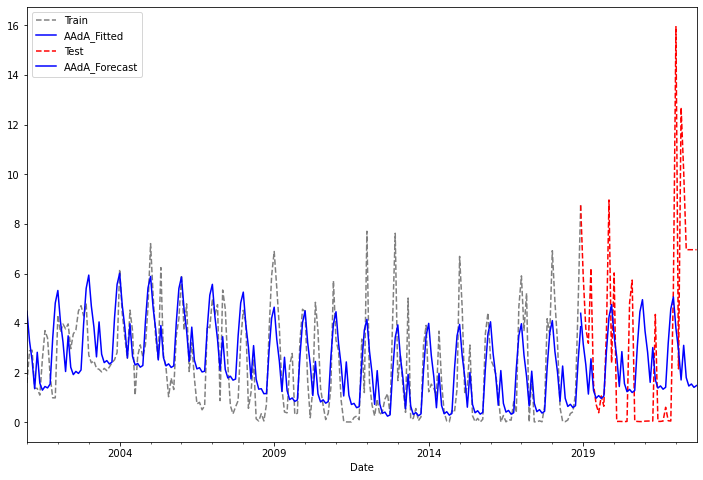

In [13]:
with mlflow.start_run():

    ets_AAdA=sm.tsa.statespace.ExponentialSmoothing(train["ptl_Con"],
                                               trend=True, 
                                               initialization_method= 'concentrated', 
                                               seasonal=12, 
                                               damped_trend=True).fit()

    fc_AAdA=ets_AAdA.forecast(len(test))

    fc_AAdA=pd.DataFrame(fc_AAdA)
    fc_AAdA.columns=['fc_AAdA']
    fc_AAdA=fc_AAdA.reset_index()
    fc_AAdA=fc_AAdA.drop('index',axis=1)
    predictions2=test.copy()
    predictions2=predictions2.reset_index()
    fc_AAdA2 = pd.concat([predictions2,fc_AAdA],axis=1)
    fc_AAdA2=fc_AAdA2.set_index('Month')
    fc_AAdA2=fc_AAdA2.reset_index()
    fc_AAdA2['D'] = fc_AAdA2['Month'].str.slice(0, 2)
    fc_AAdA2['M'] = fc_AAdA2['Month'].str.slice(3, 5)
    fc_AAdA2['Y'] = fc_AAdA2['Month'].str.slice(6, 10)
    fc_AAdA2['Date1'] = fc_AAdA2['Y']+'-'+fc_AAdA2['M']+'-'+fc_AAdA2['D']
    fc_AAdA2['Date'] = pd.to_datetime(fc_AAdA2['Date1'])
    fc_AAdA2=fc_AAdA2[['Date','ptl_Con','fc_AAdA']]
    fc_AAdA2=fc_AAdA2.set_index('Date')
    fc_AAdA2

    ets_AAdA2=pd.DataFrame(ets_AAdA.fittedvalues)
    ets_AAdA2=ets_AAdA2.reset_index()
    ets_AAdA2['D'] = ets_AAdA2['Month'].str.slice(0, 2)
    ets_AAdA2['M'] = ets_AAdA2['Month'].str.slice(3, 5)
    ets_AAdA2['Y'] = ets_AAdA2['Month'].str.slice(6, 10)
    ets_AAdA2['Date1'] = ets_AAdA2['Y']+'-'+ets_AAdA2['M']+'-'+ets_AAdA2['D']
    ets_AAdA2['Date'] = pd.to_datetime(ets_AAdA2['Date1'])
    ets_AAdA2=ets_AAdA2[['Date',0]]
    ets_AAdA2=ets_AAdA2.set_index('Date')
    ets_AAdA2

    train2=train.reset_index()
    train2['D'] = train2['Month'].str.slice(0, 2)
    train2['M'] = train2['Month'].str.slice(3, 5)
    train2['Y'] = train2['Month'].str.slice(6, 10)
    train2['Date1'] = train2['Y']+'-'+train2['M']+'-'+train2['D']
    train2['Date'] = pd.to_datetime(train2['Date1'])
    train2=train2[['Date','ptl_Con']]
    train2=train2.set_index('Date')
    train2

    fig = plt.figure(figsize=(10,5))
    train2["ptl_Con"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
    ets_AAdA2[0].plot(color="b", legend=True, label="AAdA_Fitted")
    fc_AAdA2["ptl_Con"].plot(style="--",color="r", legend=True, label="Test")
    fc_AAdA2["fc_AAdA"].plot(color="b", legend=True, label="AAdA_Forecast")

    #MAE
    n=mean_absolute_error(fc_AAdA2.ptl_Con, fc_AAdA2["fc_AAdA"])
    print("Mean Absolute error is",n)

    #MAPE
    k=np.mean(np.abs((fc_AAdA2.ptl_Con - fc_AAdA2["fc_AAdA"]) / fc_AAdA2.ptl_Con)) * 100
    print("MAPE is",k)

    #RMSE
    r=math.sqrt(mean_squared_error(fc_AAdA2.ptl_Con, fc_AAdA2["fc_AAdA"]))
    print("RMSE is",r)

    mlflow.log_param("model", "ETS")
    mlflow.log_metric("mae", n)
    mlflow.log_metric("mape", k)
    mlflow.log_metric("rmse", r)
    mlflow.log_figure(fig, "ETS.png")
    # Save model as artifact
    mlflow.sklearn.log_model(ets_AAdA, "model")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78358D+00    |proj g|=  2.56753D-02


 This problem is unconstrained.



At iterate    5    f=  1.75616D+00    |proj g|=  2.71065D-03

At iterate   10    f=  1.75269D+00    |proj g|=  6.33275D-03

At iterate   15    f=  1.75195D+00    |proj g|=  5.32961D-05

At iterate   20    f=  1.75192D+00    |proj g|=  2.74518D-04

At iterate   25    f=  1.75191D+00    |proj g|=  3.76668D-05

At iterate   30    f=  1.75191D+00    |proj g|=  1.71896D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     37      1     0     0   5.081D-06   1.752D+00
  F =   1.7519080412507990     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Mean Absolute error is 3.084187521469965
MAPE is 23

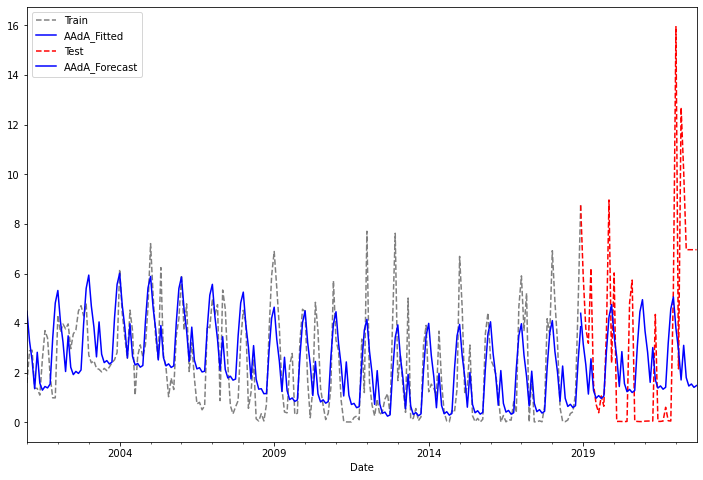

In [14]:
with mlflow.start_run():
    ets_AAdA=sm.tsa.statespace.ExponentialSmoothing(train["ptl_Con"],
                                               trend=True, 
                                               initialization_method= 'concentrated', 
                                               seasonal=12, 
                                               damped_trend=True).fit()

    fc_AAdA=ets_AAdA.forecast(len(test))

    fc_AAdA=pd.DataFrame(fc_AAdA)
    fc_AAdA.columns=['fc_AAdA']
    fc_AAdA=fc_AAdA.reset_index()
    fc_AAdA=fc_AAdA.drop('index',axis=1)
    predictions2=test.copy()
    predictions2=predictions2.reset_index()
    fc_AAdA2 = pd.concat([predictions2,fc_AAdA],axis=1)
    fc_AAdA2=fc_AAdA2.set_index('Month')
    fc_AAdA2=fc_AAdA2.reset_index()
    fc_AAdA2['D'] = fc_AAdA2['Month'].str.slice(0, 2)
    fc_AAdA2['M'] = fc_AAdA2['Month'].str.slice(3, 5)
    fc_AAdA2['Y'] = fc_AAdA2['Month'].str.slice(6, 10)
    fc_AAdA2['Date1'] = fc_AAdA2['Y']+'-'+fc_AAdA2['M']+'-'+fc_AAdA2['D']
    fc_AAdA2['Date'] = pd.to_datetime(fc_AAdA2['Date1'])
    fc_AAdA2=fc_AAdA2[['Date','ptl_Con','fc_AAdA']]
    fc_AAdA2=fc_AAdA2.set_index('Date')
    fc_AAdA2

    ets_AAdA2=pd.DataFrame(ets_AAdA.fittedvalues)
    ets_AAdA2=ets_AAdA2.reset_index()
    ets_AAdA2['D'] = ets_AAdA2['Month'].str.slice(0, 2)
    ets_AAdA2['M'] = ets_AAdA2['Month'].str.slice(3, 5)
    ets_AAdA2['Y'] = ets_AAdA2['Month'].str.slice(6, 10)
    ets_AAdA2['Date1'] = ets_AAdA2['Y']+'-'+ets_AAdA2['M']+'-'+ets_AAdA2['D']
    ets_AAdA2['Date'] = pd.to_datetime(ets_AAdA2['Date1'])
    ets_AAdA2=ets_AAdA2[['Date',0]]
    ets_AAdA2=ets_AAdA2.set_index('Date')
    ets_AAdA2

    train2=train.reset_index()
    train2['D'] = train2['Month'].str.slice(0, 2)
    train2['M'] = train2['Month'].str.slice(3, 5)
    train2['Y'] = train2['Month'].str.slice(6, 10)
    train2['Date1'] = train2['Y']+'-'+train2['M']+'-'+train2['D']
    train2['Date'] = pd.to_datetime(train2['Date1'])
    train2=train2[['Date','ptl_Con']]
    train2=train2.set_index('Date')
    train2
    
    #Plotting
    fig = plt.figure(figsize=(10,5))
    train2["ptl_Con"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
    ets_AAdA2[0].plot(color="b", legend=True, label="AAdA_Fitted")
    fc_AAdA2["ptl_Con"].plot(style="--",color="r", legend=True, label="Test")
    fc_AAdA2["fc_AAdA"].plot(color="b", legend=True, label="AAdA_Forecast")

    #MAE
    n=mean_absolute_error(fc_AAdA2.ptl_Con, fc_AAdA2["fc_AAdA"])
    print("Mean Absolute error is",n)

    #MAPE
    k=np.mean(np.abs((fc_AAdA2.ptl_Con - fc_AAdA2["fc_AAdA"]) / fc_AAdA2.ptl_Con)) * 100
    print("MAPE is",k)

    #RMSE
    r=math.sqrt(mean_squared_error(fc_AAdA2.ptl_Con, fc_AAdA2["fc_AAdA"]))
    print("RMSE is",r)
    
    mlflow.log_param("model", "ETS")
    mlflow.log_metric("mae", n)
    mlflow.log_metric("mape", k)
    mlflow.log_metric("rmse", r)
    mlflow.log_figure(fig, "ETS.png")
    # Save model as artifact
    mlflow.sklearn.log_model(ets_AAdA, "model")

# SARIMA

In [15]:
#ptl_data=pd.read_csv("D:\\FP2\\all commercial\\all commercial\\petroleum liquid\\Total_consumption_petroleum_liquids_Alaska_all_commercial_(total)_monthly.csv")
ptl_data=pd.read_csv("Total_consumption_petroleum_liquids_Alaska_all_commercial_(total)_monthly.csv")
ptl_data=ptl_data.rename(columns={'Series ID: ELEC.CONS_TOT.PEL-AK-96.M thousand barrels':'ptl_Con'})
mean_values = (ptl_data['ptl_Con'].shift() + ptl_data['ptl_Con'].shift(-1)) / 2

# Replace missing values with the mean of the preceding and following values
ptl_data['ptl_Con'].fillna(method='ffill', inplace=True)
ptl_data['D'] = ptl_data['Month'].str.slice(0, 2)
ptl_data['M'] = ptl_data['Month'].str.slice(3, 5)
ptl_data['Y'] = ptl_data['Month'].str.slice(6, 10)
ptl_data['Date1'] = ptl_data['Y']+'-'+ptl_data['M']+'-'+ptl_data['D']
ptl_data['Date'] = pd.to_datetime(ptl_data['Date1'])
ptl_data3=ptl_data.sort_values(['Date'],ascending=True)
ptl_data4=ptl_data3[['Date','ptl_Con']]
df = ptl_data4.set_index("Date")
y=df['ptl_Con']
y_to_val = y['2018-12-01':] # dataset to train
y_to_train = y[:'2018-12-01'] # last X months for test  
#predict_date = len(y) - len(y[:'Q4 2017']-1) 
train=pd.DataFrame(y_to_train)
test=pd.DataFrame(y_to_val)


In [16]:
# determining the parameters
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
               
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

sarima_grid_search(y,12)

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64374D+00    |proj g|=  8.75792D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   3.660D-07   2.644D+00
  F =   2.6437381155536808     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.5

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.13954D+00    |proj g|=  5.61960D-02

At iterate   10    f=  2.13656D+00    |proj g|=  7.65776D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     16      1     0     0   3.094D-05   2.137D+00
  F =   2.1365478338094044     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.10864D+00    |proj g|=  3.74722D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   3.747D-06   2.109D+00
  F =   2.1086378877274852     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.0

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.41176D+00    |proj g|=  9.62358D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7      9      1     0     0   4.662D-05   2.412D+00
  F =   2.4117560367717390     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31730D+00    |proj g|=  1.63499D-01

At iterate    5    f=  2.26148D+00    |proj g|=  8.69741D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.95155D+00    |proj g|=  1.32166D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   1.084D-05   1.952D+00
  F =   1.9515398012744434     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30187D+00    |proj g|=  2.92094D-01

At iterate    5    f=  2.20858D+00    |proj g|=  4.16113D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.08009D+00    |proj g|=  1.65842D-01

At iterate   10    f=  2.04933D+00    |proj g|=  7.33668D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     23      1     0     0   2.588D-05   2.049D+00
  F =   2.0493285510033146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.05897D+00    |proj g|=  9.42707D-02

At iterate    5    f=  2.03473D+00    |proj g|=  5.35109D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   1.300D-05   2.035D+00
  F =   2.0347275870766026     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.27670D+00    |proj g|=  2.72880D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   4.323D-06   2.277D+00
  F =   2.2766893097472192     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.1

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08537D+00    |proj g|=  1.07662D-01

At iterate    5    f=  2.05220D+00    |proj g|=  1.31952D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7      9      1     0     0   1.476D-06   2.052D+00
  F =   2.0521945242420592     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.19155D+00    |proj g|=  3.35847D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   3.358D-06   2.192D+00
  F =   2.1915524641421400     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06635D+00    |proj g|=  8.98704D-02

At iterate    5    f=  2.03774D+00    |proj g|=  1.64916D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   2.467D-06   2.038D+00
  F =   2.0377325003900424     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.09063D+00    |proj g|=  2.17533D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   3.902D-06   2.091D+00
  F =   2.0906301460681482     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24617D+00    |proj g|=  1.17060D-01

At iterate    5    f=  2.23465D+00    |proj g|=  4.78298D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98326D+00    |proj g|=  1.51160D-01

At iterate    5    f=  1.91257D+00    |proj g|=  1.17340D-02

At iterate   10    f=  1.91219D+00    |proj g|=  8.60075D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     14      1     0     0   4.140D-06   1.912D+00
  F =   1.9121920737577123     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.15330D+00    |proj g|=  5.89376D-01

At iterate    5    f=  2.04779D+00    |proj g|=  6.96783D-02

At iterate   10    f=  2.01523D+00    |proj g|=  3.88059D-02

At iterate   15    f=  2.01189D+00    |proj g|=  9.38202D-03

At iterate   20    f=  2.01179D+00    |proj g|=  3.03266D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     29      1     0     0   3.134D-05   2.012D+00
  F =   2.0117870539694906     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH    

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.05298D+00    |proj g|=  8.97576D-02

At iterate    5    f=  2.02849D+00    |proj g|=  3.40569D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   3.815D-06   2.028D+00
  F =   2.0284885326612563     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.22281D+00    |proj g|=  1.14230D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     11      1     0     0   1.141D-05   2.223D+00
  F =   2.2228137432243487     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.1

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98662D+00    |proj g|=  1.18308D-01

At iterate    5    f=  1.92414D+00    |proj g|=  6.37965D-04


 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      8      1     0     0   1.154D-05   1.924D+00
  F =   1.9241424098015396     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23079D+00    |proj g|=  3.92664D-01

At iterate    5    f=  2.11885D+00    |proj g|=  9.69323D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.00387D+00    |proj g|=  1.49399D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   3.696D-06   2.004D+00
  F =   2.0038657919634999     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.99560D+00    |proj g|=  1.09054D-01

At iterate    5    f=  1.91897D+00    |proj g|=  2.37648D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08824D+00    |proj g|=  8.75493D-02

At iterate    5    f=  2.08199D+00    |proj g|=  1.01160D-02

At iterate   10    f=  2.08195D+00    |proj g|=  1.90302D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   1.903D-05   2.082D+00
  F =   2.0819509179716751     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.21741D+00    |proj g|=  9.50044D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   9.500D-06   2.217D+00
  F =   2.2174106749805675     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.96311D+00    |proj g|=  1.20993D-01

At iterate    5    f=  1.89781D+00    |proj g|=  3.63351D-03

At iterate   10    f=  1.89764D+00    |proj g|=  1.30937D-04

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.99556D+00    |proj g|=  1.12837D-01

At iterate   10    f=  1.99430D+00    |proj g|=  2.26629D-03

At iterate   15    f=  1.99430D+00    |proj g|=  7.79848D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   3.929D-05   1.994D+00
  F =   1.9942966457547422     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.01244D+00    |proj g|=  8.59447D-02

At iterate    5    f=  1.99334D+00    |proj g|=  6.14415D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   5.841D-06   1.993D+00
  F =   1.9932403603288480     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.22060D+00    |proj g|=  5.56328D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.563D-06   2.221D+00
  F =   2.2205954427190937     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.1

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02987D+00    |proj g|=  1.41389D-01

At iterate    5    f=  1.96950D+00    |proj g|=  8.98103D-03

At iterate   10    f=  1.96848D+00    |proj g|=  4.12492D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     18      1     0     0   4.125D-06   1.968D+00
  F =   1.9684818107330764     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.17215D+00    |proj g|=  5.60490D-01

At iterate    5    f=  2.09215D+00    |proj g|=  9.52822D-02

At iterate   10    f=  2.06886D+00    |proj g|=  2.93687D-02

At iterate   15    f=  2.06819D+00    |proj g|=  1.44766D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     22      1     0     0   4.411D-05   2.068D+00
  F =   2.0681911594180296     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08701D+00    |proj g|=  7.68100D-02

At iterate    5    f=  2.06912D+00    |proj g|=  1.42631D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   1.247D-06   2.069D+00
  F =   2.0691206884864894     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.05311D+00    |proj g|=  7.64851D-02

At iterate   10    f=  2.04939D+00    |proj g|=  9.20056D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     22      1     0     0   7.458D-07   2.049D+00
  F =   2.0493502745281815     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24546D+00    |proj g|=  1.18555D-01

At iterate    5    f=  2.22644D+00    |proj g|=  7.63759D-04


 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   1.597D-05   2.226D+00
  F =   2.2264370203362733     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98289D+00    |proj g|=  1.51436D-01

At iterate    5    f=  1.90273D+00    |proj g|=  2.25642D-02

At iterate   10    f=  1.90133D+00    |proj g|=  1.18546D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate   15    f=  2.05481D+00    |proj g|=  9.70307D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     21      1     0     0   9.564D-06   2.055D+00
  F =   2.0548090593961361     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.15046D+00    |proj g|=  5.84075D-01

At iterate    5    f=  2.04773D+00    |proj g|=  1.28324D-01

At iterate   10    f=  2.00293D+00    |proj g|=  1.69215D-01

At iterate   15    f=  2.00021D+00    |proj g|=  5.61152D-02

At iterate   20    f=  1.99955D+00    |proj g|=  4.60310D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     35      1     0     0   4.823D-05   2.000D+00
  F =   1.9995503700137414     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  2.00399D+00    |proj g|=  1.03373D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     13      1     0     0   4.027D-06   2.004D+00
  F =   2.0036387003749190     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.99135D+00    |proj g|=  1.26240D-01


 This problem is unconstrained.



At iterate    5    f=  1.90017D+00    |proj g|=  1.33015D-02

At iterate   10    f=  1.89979D+00    |proj g|=  5.31959D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   5.320D-06   1.900D+00
  F =   1.8997878051145376     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The set of parameters with the minimum AIC is: SARIMA(1, 0, 1)x(0, 1, 1, 12) - AIC:998.5659446429594


In [17]:
import pmdarima as pm

In [18]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    fig = plt.figure(figsize=(10,5))
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    k=mean_absolute_error(y_forecasted, y_to_test)
    n=np.mean(np.abs((y_to_test - y_forecasted) / y_to_test)) * 100
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    fig1 = plt.figure(figsize=(10,5))
    print("Mean Absolute error :",k)
    print("MAPE is :",n)
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))
    fig1 = plt.figure(figsize=(10,5))
    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    k_dynamic=mean_absolute_error(y_forecasted_dynamic, y_to_test)
    n_dynamic=np.mean(np.abs((y_to_test - y_forecasted_dynamic) / y_to_test)) * 100
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    r=round(np.sqrt(mse_dynamic), 2)
    print("Mean Absolute error :",k_dynamic)
    print("MAPE is :",n_dynamic)
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))
    fig2 = plt.figure(figsize=(10,5))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    with mlflow.start_run():
        #log the params
        mlflow.log_param("model", "SARIMA")
        #log the metrics
        mlflow.log_metric("mae", k_dynamic)
        mlflow.log_metric("mape", n_dynamic)
        mlflow.log_metric("rmse", r)
        #log the plot
        mlflow.log_figure(fig2, "SARIMA.png")
        # Save model as artifact
        mlflow.pmdarima.log_model(results, "model")
    
    return (results)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.96311D+00    |proj g|=  1.20993D-01


 This problem is unconstrained.



At iterate    5    f=  1.89781D+00    |proj g|=  3.63351D-03

At iterate   10    f=  1.89764D+00    |proj g|=  1.30937D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   3.658D-05   1.898D+00
  F =   1.8976359092777000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7878      0.062     12.743      0.000       0.667       0.909
ma.L1         -0.4095      0.075     -5.462      0.000      -0

<Figure size 720x360 with 0 Axes>

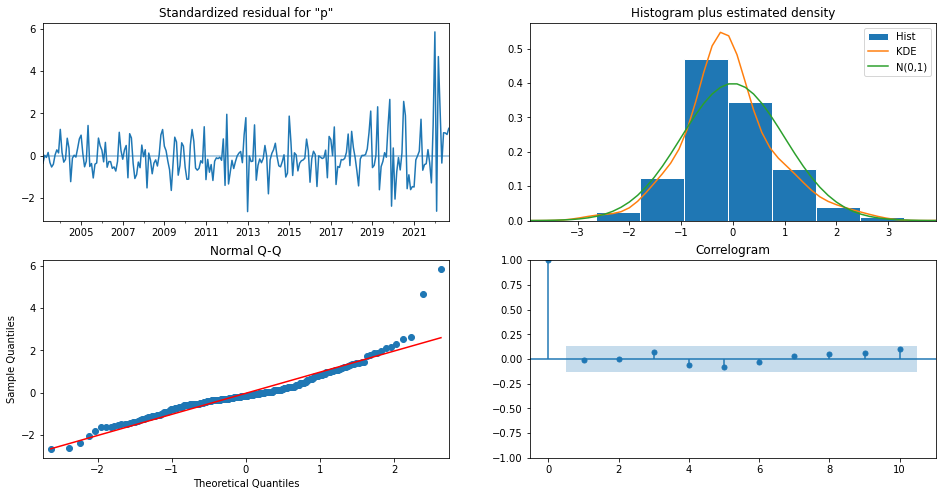

Mean Absolute error : 2.40461636011428
MAPE is : 1504.06108953326
The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = False 3.3


<Figure size 720x360 with 0 Axes>

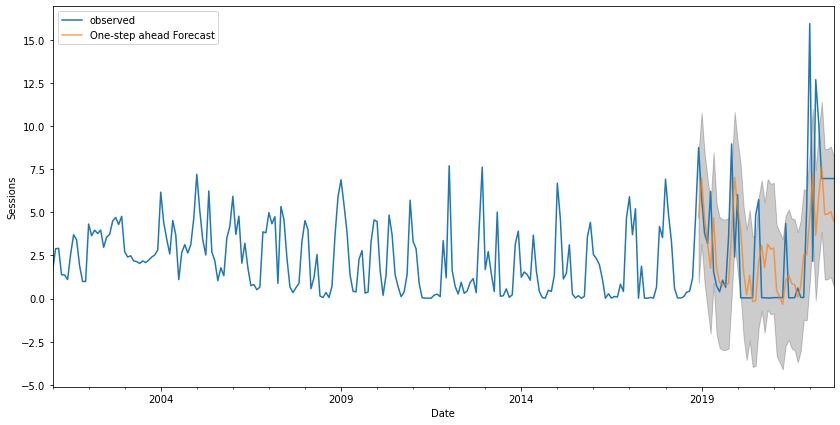

Mean Absolute error : 2.9118604952256377
MAPE is : 2023.0715608742698
The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = True 3.91


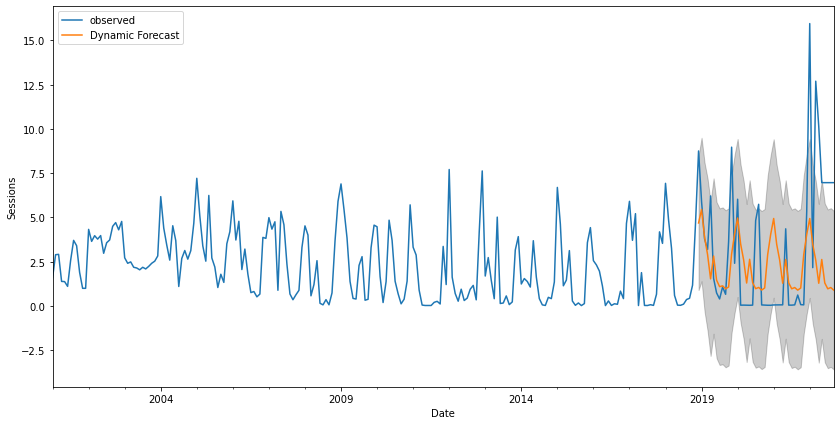

In [19]:
model = sarima_eva(y,(1, 0, 1),(0, 1, 1, 12),12,'2018-12-01',y_to_val)

In [20]:
# price forecasting
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)
    pred_ci = pred_uc.conf_int()
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    
    
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    
    pci2=pci.set_index('Date')
    pm2=pm.set_index('Date')
    ax = y.plot(label='observed', figsize=(14, 7))
    pm2.plot(ax=ax, label='Forecast')
    ax.fill_between(pci2.index,
                    pci2.iloc[:, 0],
                    pci2.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()

    final_table = pm.join(pci.set_index('Date'), on='Date')
    final_table=final_table.set_index('Date')
    return (final_table)

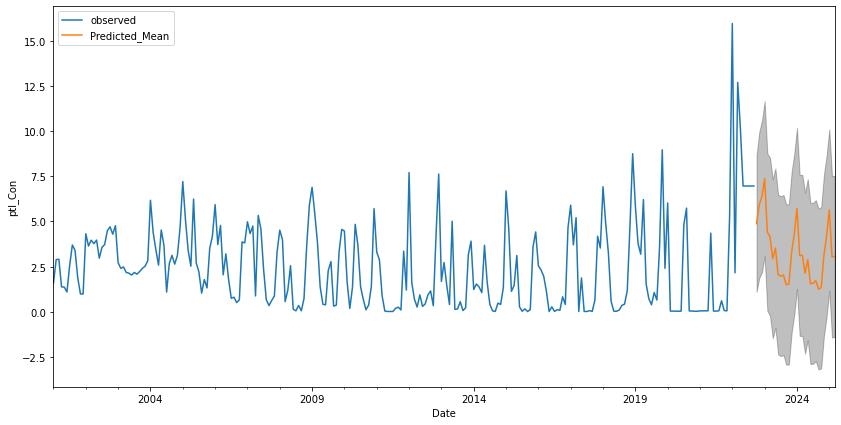

In [21]:
forecast_table = forecast(model,30,y)

In [22]:
forecast_table.to_csv('forecast_petroluemliquid_values.csv')